# Machine Learning for Business Decisions: Assignment 1

<b>Group 14: Rylie Ramos-Marquez, Derek Atabayev, Vishnu Garigipati</b>

Are employees likely to resign?

In [1]:
# all necessary imports
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
import optuna

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

from scipy.stats import randint, uniform

import joblib # for saving the model


In [2]:
# Save both available and competition datasets as pd.DataFrame


available_data = pd.read_pickle("attrition_available_14.pkl").copy()
competition_data = pd.read_pickle("attrition_compet_14.pkl").copy()

Part 1: Exploratory EDA

Maniupating the dataframe available_data to gain insights

In [3]:
available_data.reset_index(drop=True, inplace=True)

print(available_data.info()) # inspect column types and counts
# we can see that this dataset is about 1426 unique employees (1281 of them have ID) and various fields relating to their employment


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1426 entries, 0 to 1425
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hrs                      1426 non-null   float64
 1   absences                 1426 non-null   int64  
 2   JobInvolvement           1279 non-null   float64
 3   PerformanceRating        1278 non-null   float64
 4   EnvironmentSatisfaction  1419 non-null   float64
 5   JobSatisfaction          1420 non-null   float64
 6   WorkLifeBalance          1414 non-null   float64
 7   Age                      1426 non-null   int64  
 8   Attrition                1426 non-null   object 
 9   BusinessTravel           1426 non-null   object 
 10  Department               1426 non-null   object 
 11  DistanceFromHome         1426 non-null   int64  
 12  Education                1426 non-null   int64  
 13  EducationField           1426 non-null   object 
 14  EmployeeCount           

In [4]:
# find the number of features and instances

print(available_data.shape)
# shape returns a tupe of (instances, features) which is (1426, 35)
# however from above we can see there are missing values for EmployeeID in 1426 - 1281 = 145 rows

(1426, 31)


In [5]:
# check which variables are categorical / numerical

print(available_data.dtypes)
# we can see that the majority of the columns are numerical, with the exception of the following:
# Attrition, BusinessTravel, Department, Education, Gender, Job Role, MaritalStatus, Over18


hrs                        float64
absences                     int64
JobInvolvement             float64
PerformanceRating          float64
EnvironmentSatisfaction    float64
JobSatisfaction            float64
WorkLifeBalance            float64
Age                          int64
Attrition                   object
BusinessTravel              object
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeID                 float64
Gender                      object
JobLevel                     int64
JobRole                     object
MaritalStatus               object
MonthlyIncome                int64
NumCompaniesWorked         float64
Over18                      object
PercentSalaryHike            int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears          float64
TrainingTimesLastYear        int64
YearsAtCompany      

In [6]:
# from the categorical variables: Attrition, BusinessTravel, Department, EducationField, Gender, Job Role, MaritalStatus, Over18, check which have high cardinality

list_of_categorical = ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18']

# print cardinality for each
for col in list_of_categorical:
    if available_data[col].nunique() > 5: # check if cardinalty > 5, then this is considered high cardinality
        print(col, "is high cardinality")

# observe that EducationField and JobRole are high cardinality

print("Values for EducationField: ", available_data['EducationField'].unique()) # spans an all-encompassing range of education fields
print("Values for JobRole Field: " , available_data['JobRole'].unique()) # contains 9 unique job roles as possible fields

EducationField is high cardinality
JobRole is high cardinality
Values for EducationField:  ['Life Sciences' 'Medical' 'Human Resources' 'Marketing'
 'Technical Degree' 'Other']
Values for JobRole Field:  ['Research Scientist' 'Sales Executive' 'Manager' 'Laboratory Technician'
 'Manufacturing Director' 'Healthcare Representative'
 'Sales Representative' 'Research Director' nan 'Human Resources']


In [7]:
# Check columns that have missing values

print(available_data.isnull().sum()[available_data.isnull().sum() > 0])
# filter by columns that have missing values

# 9 features have missing values, with the most missing in JobInvolvement, PerformanceRating, EmployeeID, JobRole


JobInvolvement             147
PerformanceRating          148
EnvironmentSatisfaction      7
JobSatisfaction              6
WorkLifeBalance             12
EmployeeID                 145
JobRole                    134
NumCompaniesWorked           5
TotalWorkingYears            4
dtype: int64


In [8]:
# Check whether there are constant columns

print("Constant Columns: ", available_data.columns[available_data.nunique() == 1]) # if the number of unique values in a column is 1, then it is a constant column

# there are three constant columns in the dataset: Over18, StandardHours, EmployeeCount

print(available_data['Over18'].unique()) # only one unique value
print(available_data['StandardHours'].unique())
print(available_data['EmployeeCount'].unique())


Constant Columns:  Index(['EmployeeCount', 'Over18', 'StandardHours'], dtype='object')
['Y']
[8]
[1]


In [9]:
# inspecting the columns suggests all employees are Over18, all work standard hours, and there is only one employee count per row
# delete these constant columns
available_data.drop(columns=['Over18', 'StandardHours', 'EmployeeCount'], inplace=True)
competition_data.drop(columns=['Over18', 'StandardHours', 'EmployeeCount'], inplace=True)

In [10]:
# Attrition is the target variable in this problem

print(available_data['Attrition'].value_counts())



Attrition
No     715
Yes    711
Name: count, dtype: int64


So, this is a binary classification problem

Balanced dataset, with 715 employees who have not left the company and 711 employees who have left the company

This means every row has a target value, so we do not need to drop any rows

Next, we can print a correlation matrix using Seaborn "heatmap"

This will tell us the correlation between variables, and also whether there is any multicollinearity, etc.

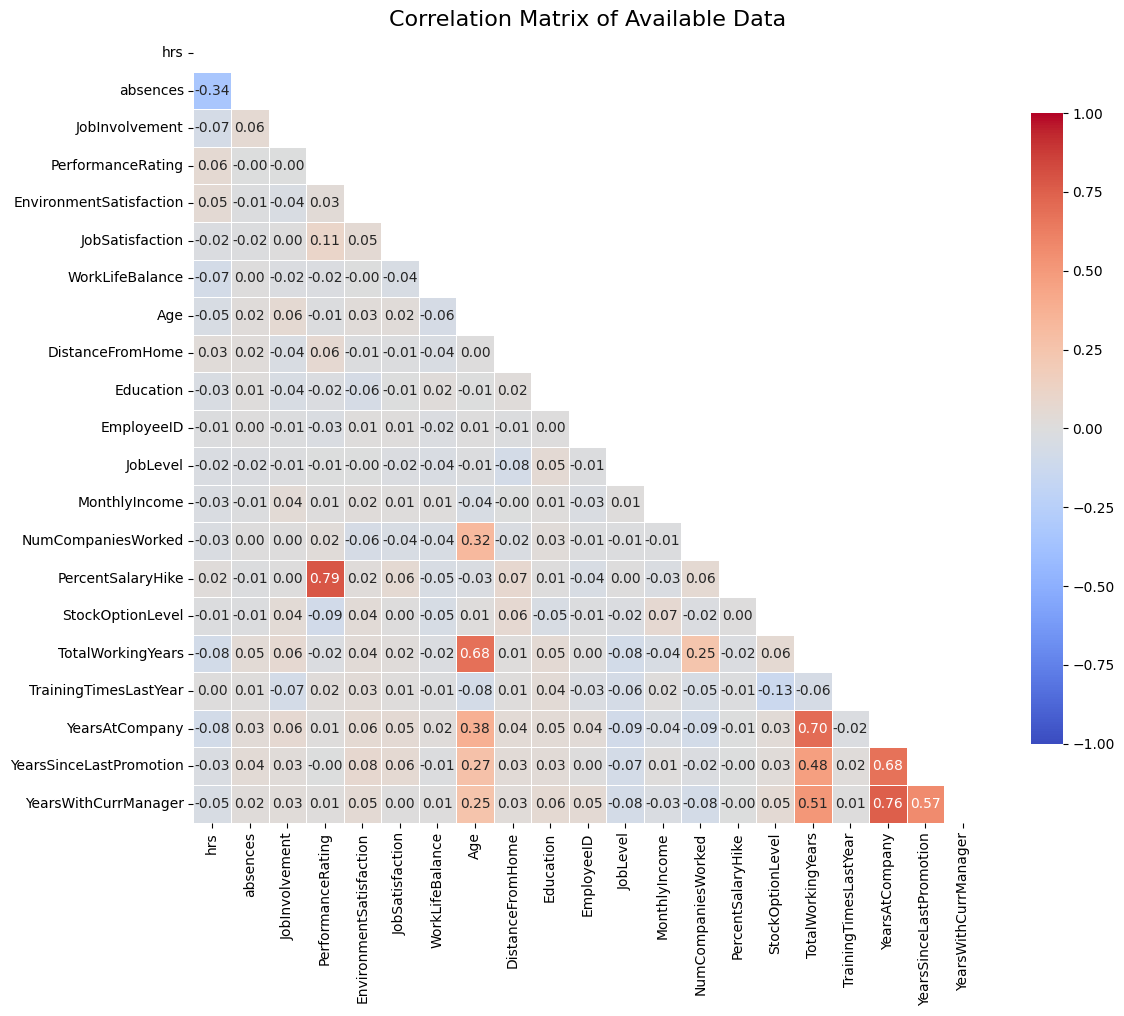

In [11]:
corr_matrix = available_data.corr(numeric_only=True)

# Set up the figure size
plt.figure(figsize=(12, 10))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # create a mask to only show the lower triangle of the matrix

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', mask=mask, cbar_kws={'shrink': 0.8}, annot_kws={'size': 10}, linewidths=0.5, square=True,vmin=-1, vmax=1)           

# Add a title
plt.title('Correlation Matrix of Available Data', fontsize=16)

# Display the plot
plt.tight_layout()
plt.show()

From this correlation matrix, we can observe that the highest correlation is between Performance rating and Percent Salary Hike as well as Years at company and years with current manager but the correlation is not high enough (< 0.9) to drop these features entirely

Part 2: Basic Methods (Trees, KNN, and Logistic Regression)

General decisions:

1. Split 70% train, 30% test, because the dataset is small, and we need a large enough test size to help detect overfitting

2. Will return also a classification report: precision, recall, f1-score, and support, because this gives a more comprehensive view
 - Precision is especially valuable because it essentially checks how reliable our predictions (in the positive case are)
 - Support prevents any random imbalances that could have occured

In [12]:

# Define feature matrix X and target vector y
X = available_data.drop(columns=['Attrition'])
y = available_data['Attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100545358)


Method One (default hyperparamaters): Decision Trees

In [13]:

# Use a pipeline

# Encode the target variable 
label_encoder = LabelEncoder() # 0 for No, 1 for Yes
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define the preprocessor
# scale

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')), # impute missing values with the mean
            ('scaler', MinMaxScaler()) # scale the numerical features
        ]), X.select_dtypes(include=['int64', 'float64']).columns)
    ])
# the preprocessor will impute missing values with the mean and scale the numerical features

# Define the model

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', DecisionTreeClassifier(random_state=100545358))]) # steps to be completed in order


# Fit the model
start = time.time()
model.fit(X_train, y_train_encoded)
end = time.time()

print("Training time: ", end - start)

# Predict the target values
y_pred = model.predict(X_test)

# Calculate the accuracy

accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy: ", accuracy)

# Also return a classification report 
print(classification_report(y_test_encoded, y_pred))

# this returns a classification report with precision, recall, f1-score, and support for each class



Training time:  0.019778013229370117
Accuracy:  0.8060747663551402
              precision    recall  f1-score   support

           0       0.86      0.74      0.79       216
           1       0.77      0.88      0.82       212

    accuracy                           0.81       428
   macro avg       0.81      0.81      0.81       428
weighted avg       0.81      0.81      0.81       428



Method Two (default hyperparameters): KNN

In [14]:

# Define the model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', KNeighborsClassifier())])

# Fit the model

start = time.time()
model.fit(X_train, y_train_encoded)
end = time.time()

print("Training time: ", end - start)

# Predict the target values
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy: ", accuracy)

print (classification_report(y_test_encoded, y_pred))

Training time:  0.006854534149169922
Accuracy:  0.7079439252336449
              precision    recall  f1-score   support

           0       0.71      0.70      0.71       216
           1       0.70      0.71      0.71       212

    accuracy                           0.71       428
   macro avg       0.71      0.71      0.71       428
weighted avg       0.71      0.71      0.71       428



Method Three (default hyperparameters): Logistic Regression

In [15]:

# Define the model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression(random_state=100545358))])

# Fit the model

start = time.time()
model.fit(X_train, y_train_encoded)
end = time.time()

print("Training time: ", end - start)

# Predict the target values
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test_encoded, y_pred)

print("Accuracy: ", accuracy)

print(classification_report(y_test_encoded, y_pred))

Training time:  0.017003536224365234
Accuracy:  0.6705607476635514
              precision    recall  f1-score   support

           0       0.67      0.68      0.67       216
           1       0.67      0.67      0.67       212

    accuracy                           0.67       428
   macro avg       0.67      0.67      0.67       428
weighted avg       0.67      0.67      0.67       428



In order of performance:

Decision Trees performs best, followed by Logistic Regression and KNN

Part 3: We can check if it is justifiable to switch to an 80/20 split so that KNN and Logistic Regression might be able to perform better

In [16]:
# Change testing split to 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100545358)

# Re-encode the target variable
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print("Logistic Regression with 0.2 testing split")
# Define the model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression(random_state=100545358))])

# Fit the model
start = time.time()
model.fit(X_train, y_train_encoded)
end = time.time()

print("Training time: ", end - start)

# Predict the target values
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy: ", accuracy)
print(classification_report(y_test_encoded, y_pred))

print("KNN with 0.2 testing split")
# Define the model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', KNeighborsClassifier())])

# Fit the model
start = time.time()
model.fit(X_train, y_train_encoded)
end = time.time()

print("Training time: ", end - start)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy: ", accuracy)
print(classification_report(y_test_encoded, y_pred))

print("Decision Tree with 0.2 testing split")

# Define the model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', DecisionTreeClassifier(random_state=100545358))])

# Fit the model
start = time.time()
model.fit(X_train, y_train_encoded)
end = time.time()

print("Training time: ", end - start)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy: ", accuracy)
print(classification_report(y_test_encoded, y_pred))



Logistic Regression with 0.2 testing split
Training time:  0.0191042423248291
Accuracy:  0.6783216783216783
              precision    recall  f1-score   support

           0       0.69      0.65      0.67       142
           1       0.67      0.71      0.69       144

    accuracy                           0.68       286
   macro avg       0.68      0.68      0.68       286
weighted avg       0.68      0.68      0.68       286

KNN with 0.2 testing split
Training time:  0.0050013065338134766
Accuracy:  0.7307692307692307
              precision    recall  f1-score   support

           0       0.73      0.73      0.73       142
           1       0.73      0.74      0.73       144

    accuracy                           0.73       286
   macro avg       0.73      0.73      0.73       286
weighted avg       0.73      0.73      0.73       286

Decision Tree with 0.2 testing split
Training time:  0.016362428665161133
Accuracy:  0.8636363636363636
              precision    recall  f1-s

Our two strongest methods are Decision Trees and KNN.

In the cases we tested (reproducible with the random_state = 100545358), the support does not show any imbalances, so we can stick with this split

Both methods are slightly more accurate using the 80/20 split. In addition, decision trees are more precise in each case. With the 70/30 split, the decision trees were slightly less precise in the positive case. Here, we can see the precision is more even, and also greater.

Therefore, it is justifiable to keep the 80/20 split.

Part 4: Compare with the Dummy Method 

In [17]:
# using DummyClassifier as a baseline

dummy = DummyClassifier(strategy='most_frequent', random_state = 100545358)
dummy.fit(X_train, y_train_encoded)

y_pred = dummy.predict(X_test)

dummy_accuracy = accuracy_score(y_test_encoded, y_pred)
print("Dummy Classifier Accuracy: ", dummy_accuracy)
print(classification_report(y_test_encoded, y_pred))



Dummy Classifier Accuracy:  0.4965034965034965
              precision    recall  f1-score   support

           0       0.50      1.00      0.66       142
           1       0.00      0.00      0.00       144

    accuracy                           0.50       286
   macro avg       0.25      0.50      0.33       286
weighted avg       0.25      0.50      0.33       286



c:\Users\derek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\derek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\derek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

The dummy classifier has an accuracy of 0.5, and precision/recall/f1-score of 0 in the 1 class

The 1 class is the class (positive) is the one that has left the company, so the dummy classifier is predicting that no one has left the company

Therefore, the decision tree (our final basic chosen method) is stronger than the dummy method


Visualization of Methods: Confusion Matrix 

We can use this visualization to see how many False Positives and False Negatives are being predicted by our model, to see how it is performing overall

One way of making good decisions for this problem is by minimizing both of these values, so let's see how we did.

In [18]:
# variables are reset because of the dummy method, so we need to call our models again

def generate_confusion_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
# Method 1: Decision Tree
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', DecisionTreeClassifier(random_state=100545358))])

model.fit(X_train, y_train_encoded) # data is already set to 80/20 split
y_pred = model.predict(X_test)

print("Decision Tree Confusion Matrix")
generate_confusion_matrix(model, X_test, y_test_encoded)

# Method 2: KNN
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', KNeighborsClassifier())])

model.fit(X_train, y_train_encoded) # data is already set to 80/20 split
y_pred = model.predict(X_test)

print("KNN Confusion Matrix")
generate_confusion_matrix(model, X_test, y_test_encoded)


Decision Tree Confusion Matrix
[[116  26]
 [ 13 131]]
KNN Confusion Matrix
[[103  39]
 [ 38 106]]


The classification report essentially manipulates the values in the confusion matrix to generate the statistics (precision, recall, etc.)

Decision Tree methods are far better performing, generating fewer False Negatives (26) and False Positives (16). The confusion matrix for KNN suggests a drop in model performance and indicates potential overfitting or poor hyperparameter tuning for that model.

### Part 3: Hyper Parameter Optimization

#### HyperParameter Optimization usnig our two best Models are DecisionTree and KNN

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100545358)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
            ('scaler', MinMaxScaler())  # Scale the numerical features
        ]), X.select_dtypes(include=['int64', 'float64']).columns)
    ])


1. Decision Trees

In [ ]:

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', DecisionTreeClassifier(random_state=100545358))])

# Define the parameter grid (same for all 3 methods)
# Using a list of values to try for each hyperparameter, as GridSearchCV requires (discrete distribution)
param_grid = {
    'classifier__max_depth': [3, 5, 7, 10, None],  # Max depth of the tree
    'classifier__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'classifier__min_samples_leaf': [1, 2, 5],     # Minimum number of samples required to be at a leaf node
    'classifier__criterion': ['gini', 'entropy'],   # Splitting criteria
    'classifier__max_features': ['sqrt', 'log2', None]  # Max features for each split
}

# Here we can use GridSearchCV (exhaustive search) to find the best hyperparameters, RandomizedSearchCV (not all combinations are tried) or Optuna (hyperparameter optimization framework)

# 1. **GridSearchCV**
print("Starting GridSearchCV...\n")
start = time.time()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0) # 5-fold cross validation because we have 80/20 split
# Grid search works by training the model on all possible combinations of hyperparameters (total number 5 x 3 x 3 x 2 x 3 = 90), and then selecting the best one
grid_search.fit(X_train, y_train_encoded)
grid_search_time = time.time() - start

print(f"GridSearchCV Best Hyperparameters: {grid_search.best_params_}")
y_pred = grid_search.best_estimator_.predict(X_test)
print(f"F1 Score: {f1_score(y_test_encoded, y_pred)}")
print(f"GridSearchCV Training Time: {grid_search_time:.2f} seconds\n")



Starting GridSearchCV...

GridSearchCV Best Hyperparameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
F1 Score: 0.842809364548495
GridSearchCV Training Time: 5.29 seconds



In [ ]:
# parameters sampled from a distribution
param_dist = {
    'classifier__max_depth': randint(3, 20).rvs(size=3),  # Randomly sample max depth from 3 to 20
    'classifier__min_samples_split': randint(2, 20).rvs(size=3),  # Randomly sample min_samples_split between 2 and 20
    'classifier__min_samples_leaf': randint(1, 10).rvs(size=3),   # Randomly sample min_samples_leaf between 1 and 10
    'classifier__criterion': ['gini', 'entropy'],      # Choose between 'gini' and 'entropy'
    'classifier__max_features': ['sqrt', 'log2', None]  # Randomly sample max_features or use 'sqrt'/'log2'
}

print("Starting GridSearchCV for Sampled Distribution...\n")
start = time.time()
grid_search = GridSearchCV(estimator=model, param_grid=param_dist, cv=5, n_jobs=-1, verbose=0) # 5-fold cross validation because we have 80/20 split
# Grid search works by training the model on all possible combinations of hyperparameters (total number 5 x 3 x 3 x 2 x 3 = 90), and then selecting the best one
grid_search.fit(X_train, y_train_encoded)
grid_search_time = time.time() - start

print(f"GridSearchCV Best Hyperparameters: {grid_search.best_params_}")
y_pred = grid_search.best_estimator_.predict(X_test)
print(f"F1 Score: {f1_score(y_test_encoded, y_pred)}")
print(f"GridSearchCV Training Time: {grid_search_time:.2f} seconds\n")


Starting GridSearchCV for Distribution...

GridSearchCV Best Hyperparameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 16, 'classifier__max_features': None, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 4}
F1 Score: 0.8203389830508474
GridSearchCV Training Time: 1.37 seconds



In [ ]:
# 2. **RandomizedSearchCV**
print("Starting RandomizedSearchCV...\n")
start = time.time()
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100, cv=5, n_jobs=-1, verbose=0, random_state=100545358)
# Randomized search will select 100 random combinations of hyperparameters from the parametric space and train the model on them
# Effectively this should be faster than GridSearchCV, but may not find the best hyperparameters

random_search.fit(X_train, y_train_encoded)
random_search_time = time.time() - start

print(f"RandomizedSearchCV Best Hyperparameters: {random_search.best_params_}")
y_pred = random_search.best_estimator_.predict(X_test)
print(f"F1 Score: {f1_score(y_test_encoded, y_pred)}")
print(f"RandomizedSearchCV Training Time: {random_search_time:.2f} seconds\n")




Starting RandomizedSearchCV...

RandomizedSearchCV Best Hyperparameters: {'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_features': None, 'classifier__max_depth': 10, 'classifier__criterion': 'gini'}
F1 Score: 0.842809364548495
RandomizedSearchCV Training Time: 0.89 seconds



In [ ]:
# 2. **RandomizedSearchCV**
print("Starting RandomizedSearchCV from a sampled distribution ...\n")
start = time.time()
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, verbose=0, random_state=100545358)
# Randomized search will select 100 random combinations of hyperparameters from the parametric space and train the model on them
# Effectively this should be faster than GridSearchCV, but may not find the best hyperparameters

random_search.fit(X_train, y_train_encoded)
random_search_time = time.time() - start

print(f"RandomizedSearchCV Best Hyperparameters: {random_search.best_params_}")
y_pred = random_search.best_estimator_.predict(X_test)
print(f"F1 Score: {f1_score(y_test_encoded, y_pred)}")
print(f"RandomizedSearchCV Training Time: {random_search_time:.2f} seconds\n")



Starting RandomizedSearchCV from a distribution ...

RandomizedSearchCV Best Hyperparameters: {'classifier__min_samples_split': 11, 'classifier__min_samples_leaf': 5, 'classifier__max_features': None, 'classifier__max_depth': 16, 'classifier__criterion': 'entropy'}
F1 Score: 0.7892976588628763
RandomizedSearchCV Training Time: 0.84 seconds



In this case of running it, we found identical results with RandomizedSearchCV and GridSearchCV, this means one of the 100 attempts was the best one found by the exhaustive grid search (though grid search was more computationally expensive)

In [24]:
# 3. **Optuna**
print("Starting Optuna...\n")

# Define the Optuna objective function
def objective(trial):
    # Define hyperparameters to tune
    max_depth = trial.suggest_categorical('max_depth', [3, 5, 7, 10, None])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_features = trial.suggest_categorical('max_features', [None, 'sqrt', 'log2'])

    # Define the model with the current hyperparameters
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', DecisionTreeClassifier(
                                max_depth=max_depth,
                                min_samples_split=min_samples_split,
                                min_samples_leaf=min_samples_leaf,
                                criterion=criterion,
                                max_features=max_features,
                                random_state=100545358))])
    
    # Train the model
    model.fit(X_train, y_train_encoded)
    
    # Predict and calculate accuracy
    y_pred = model.predict(X_test)
    accuracy = f1_score(y_test_encoded, y_pred)
    
    return accuracy


Starting Optuna...



Comments about Optuna:

Optuna works by selecting random hyperparameters from the parametric space and training the model on them

However, it also uses a technique called Bayesian optimization to select the next set of hyperparameters

This is done by building a probability model of the objective function and selecting the hyperparameters that maximize the expected improvement

It also will proceed to do a maximum of 100 trials, however, unlike the RandomizedSearchCV, it may stop early if there is no improvement in the objective function, so it may be faster

In [25]:
# Create and optimize the Optuna study
start = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
optuna_time = time.time() - start

print(f"Optuna Best Hyperparameters: {study.best_params}")
best_model = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', DecisionTreeClassifier(
                                  **study.best_params,
                                  random_state=100545358))])

best_model.fit(X_train, y_train_encoded)
y_pred = best_model.predict(X_test)
print(f"F1 Score: {f1_score(y_test_encoded, y_pred)}")
print(f"Optuna Training Time: {optuna_time:.2f} seconds\n")


[I 2024-12-02 17:26:54,725] A new study created in memory with name: no-name-87103e67-9ff3-4b6d-976c-85bc6500a8bc
[I 2024-12-02 17:26:54,746] Trial 0 finished with value: 0.8082191780821918 and parameters: {'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 2, 'criterion': 'gini', 'max_features': None}. Best is trial 0 with value: 0.8082191780821918.
[I 2024-12-02 17:26:54,759] Trial 1 finished with value: 0.6343042071197411 and parameters: {'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 5, 'criterion': 'entropy', 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8082191780821918.
[I 2024-12-02 17:26:54,773] Trial 2 finished with value: 0.6794871794871795 and parameters: {'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 2, 'criterion': 'gini', 'max_features': 'log2'}. Best is trial 0 with value: 0.8082191780821918.
[I 2024-12-02 17:26:54,795] Trial 3 finished with value: 0.6813186813186813 and parameters: {'max_depth': 5, 'min_samples_split': 10,

Optuna Best Hyperparameters: {'max_depth': None, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'entropy', 'max_features': 'log2'}
F1 Score: 0.8933333333333333
Optuna Training Time: 3.07 seconds



In this case, Optuna's F1 Score = 0.825503355704698, which is less than GridSearchCV's F1 Score: 0.842809364548495

Actually, it is impossible for Optuna to beat GridSearchCV measured by only F1 Score because Grid Search is exhaustive

For a larger set of hyperparameters, Optuna would be better because GridSearchCV would simply be too computationally expensive

But here, Optuna is inferior (it is only 1.5 seconds faster)

2. KNN

In [26]:

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', KNeighborsClassifier())])

# Define the parameter grid (same for all 3 methods)
param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 10, 15, 20],  # Number of neighbors to use
    'classifier__weights': ['uniform', 'distance'],  # Weight function used in prediction
    'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm to compute the nearest neighbors
    'classifier__leaf_size': [10, 20, 30, 40, 50],  # Leaf size for BallTree or KDTree
    'classifier__p': [1, 2],  # Power parameter for the Minkowski distance (1 = Manhattan, 2 = Euclidean)
}


# 1. **GridSearchCV**
print("Starting GridSearchCV...\n")
start = time.time()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train_encoded)
grid_search_time = time.time() - start

print(f"GridSearchCV Best Hyperparameters: {grid_search.best_params_}")
y_pred = grid_search.best_estimator_.predict(X_test)
print(f"F1 Score: {f1_score(y_test_encoded, y_pred)}")
print(f"GridSearchCV Training Time: {grid_search_time:.2f} seconds\n")

Starting GridSearchCV...

GridSearchCV Best Hyperparameters: {'classifier__algorithm': 'auto', 'classifier__leaf_size': 10, 'classifier__n_neighbors': 3, 'classifier__p': 1, 'classifier__weights': 'distance'}
F1 Score: 0.9038461538461539
GridSearchCV Training Time: 5.66 seconds



In [ ]:
param_dist = {
    'classifier__n_neighbors': randint(3, 21).rvs(size=3),  # n_neighbors remains as an integer, sampled between 3 and 20
    'classifier__weights': ['uniform', 'distance'],  # Categorical choice between 'uniform' or 'distance'
    'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Categorical choice
    'classifier__leaf_size': randint(10, 50).rvs(size=3),  # Randomly sample leaf_size between 10 and 50 (uniform continuous)
    'classifier__p': uniform(1, 2).rvs(size=3),  # Randomly sample 'p' between 1 and 2 (uniform continuous)
}
print("Starting GridSearchCV from Sampled Distribution...\n")
start = time.time()
grid_search = GridSearchCV(estimator=model, param_grid=param_dist, cv=5, n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train_encoded)
grid_search_time = time.time() - start

print(f"GridSearchCV Best Hyperparameters: {grid_search.best_params_}")
y_pred = grid_search.best_estimator_.predict(X_test)
print(f"F1 Score: {f1_score(y_test_encoded, y_pred)}")
print(f"GridSearchCV Training Time: {grid_search_time:.2f} seconds\n")

Starting GridSearchCV from Distribution...

GridSearchCV Best Hyperparameters: {'classifier__algorithm': 'auto', 'classifier__leaf_size': 36, 'classifier__n_neighbors': 13, 'classifier__p': 1.1581783411577682, 'classifier__weights': 'distance'}
F1 Score: 0.8143322475570033
GridSearchCV Training Time: 12.17 seconds



In [28]:

# 2. **RandomizedSearchCV**
print("Starting RandomizedSearchCV...\n")
start = time.time()
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100, cv=5, n_jobs=-1, verbose=0, random_state=100545358)
random_search.fit(X_train, y_train_encoded)
random_search_time = time.time() - start

print(f"RandomizedSearchCV Best Hyperparameters: {random_search.best_params_}")
y_pred = random_search.best_estimator_.predict(X_test)
print(f"F1 Score: {f1_score(y_test_encoded, y_pred)}")
print(f"RandomizedSearchCV Training Time: {random_search_time:.2f} seconds\n")

Starting RandomizedSearchCV...

RandomizedSearchCV Best Hyperparameters: {'classifier__weights': 'distance', 'classifier__p': 1, 'classifier__n_neighbors': 3, 'classifier__leaf_size': 50, 'classifier__algorithm': 'brute'}
F1 Score: 0.9038461538461539
RandomizedSearchCV Training Time: 1.46 seconds



Strong performance with high F1 Score = 0.9038461538461539
Recommends classifier_weights = "distance"; neighbors' contributions are weighted by their distance, giving closer neighbors more influence which is a very good approach for the relatively small dataset in this problem

In [ ]:
print("Starting RandomizedSearchCV from sampled distribution...\n")
start = time.time()
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, verbose=0, random_state=100545358)
random_search.fit(X_train, y_train_encoded)
random_search_time = time.time() - start

print(f"RandomizedSearchCV Best Hyperparameters: {random_search.best_params_}")
y_pred = random_search.best_estimator_.predict(X_test)
print(f"F1 Score: {f1_score(y_test_encoded, y_pred)}")
print(f"RandomizedSearchCV Training Time: {random_search_time:.2f} seconds\n")

Starting RandomizedSearchCV from distribution...

RandomizedSearchCV Best Hyperparameters: {'classifier__weights': 'distance', 'classifier__p': 1.1581783411577682, 'classifier__n_neighbors': 13, 'classifier__leaf_size': 45, 'classifier__algorithm': 'brute'}
F1 Score: 0.8143322475570033
RandomizedSearchCV Training Time: 5.58 seconds



In [30]:
# 3. **Optuna**
print("Starting Optuna...\n")

# Define the Optuna objective function
def objective(trial):
    # Define hyperparameters to tune
    max_depth = trial.suggest_categorical('max_depth', [3, 5, 7, 10, None])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_features = trial.suggest_categorical('max_features', [None, 'sqrt', 'log2'])

    # Define the model with the current hyperparameters
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', DecisionTreeClassifier(
                                max_depth=max_depth,
                                min_samples_split=min_samples_split,
                                min_samples_leaf=min_samples_leaf,
                                criterion=criterion,
                                max_features=max_features,
                                random_state=100545358))])
    
    # Train the model
    model.fit(X_train, y_train_encoded)
    
    # Predict and calculate accuracy
    y_pred = model.predict(X_test)
    accuracy = f1_score(y_test_encoded, y_pred)
    
    return accuracy

# Create and optimize the Optuna study
start = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
optuna_time = time.time() - start

print(f"Optuna Best Hyperparameters: {study.best_params}")
best_model = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', DecisionTreeClassifier(
                                  **study.best_params,
                                  random_state=100545358))])

best_model.fit(X_train, y_train_encoded)
y_pred = best_model.predict(X_test)
print(f"F1 Score: {f1_score(y_test_encoded, y_pred)}")
print(f"Optuna Training Time: {optuna_time:.2f} seconds\n")



[I 2024-12-02 17:27:22,879] A new study created in memory with name: no-name-61586e31-ab92-495f-8aab-ccc476664503
[I 2024-12-02 17:27:22,896] Trial 0 finished with value: 0.7383512544802867 and parameters: {'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 5, 'criterion': 'gini', 'max_features': 'log2'}. Best is trial 0 with value: 0.7383512544802867.
[I 2024-12-02 17:27:22,911] Trial 1 finished with value: 0.656 and parameters: {'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 4, 'criterion': 'entropy', 'max_features': 'log2'}. Best is trial 0 with value: 0.7383512544802867.
[I 2024-12-02 17:27:22,926] Trial 2 finished with value: 0.7804878048780488 and parameters: {'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'entropy', 'max_features': 'sqrt'}. Best is trial 2 with value: 0.7804878048780488.
[I 2024-12-02 17:27:22,941] Trial 3 finished with value: 0.6794871794871795 and parameters: {'max_depth': 5, 'min_samples_split': 7, 'min_sam

Starting Optuna...



[I 2024-12-02 17:27:23,012] Trial 8 finished with value: 0.6773162939297125 and parameters: {'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'gini', 'max_features': 'log2'}. Best is trial 2 with value: 0.7804878048780488.
[I 2024-12-02 17:27:23,026] Trial 9 finished with value: 0.7491166077738516 and parameters: {'max_depth': None, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'gini', 'max_features': 'sqrt'}. Best is trial 2 with value: 0.7804878048780488.
[I 2024-12-02 17:27:23,050] Trial 10 finished with value: 0.657243816254417 and parameters: {'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 2, 'criterion': 'gini', 'max_features': None}. Best is trial 2 with value: 0.7804878048780488.
[I 2024-12-02 17:27:23,074] Trial 11 finished with value: 0.779783393501805 and parameters: {'max_depth': None, 'min_samples_split': 8, 'min_samples_leaf': 2, 'criterion': 'gini', 'max_features': 'sqrt'}. Best is trial 2 with value: 0.7804878048780

Optuna Best Hyperparameters: {'max_depth': None, 'min_samples_split': 7, 'min_samples_leaf': 3, 'criterion': 'entropy', 'max_features': None}
F1 Score: 0.8278145695364238
Optuna Training Time: 2.81 seconds



The best performing Hyperparameter Optimization was Grid Search in both cases (it was equal to RandomizedSearchCV in Case 1: Decision Trees Classifier). 

Since it is exhaustive, it makes sense that it will be strongest (all combinations of hyperparameters can be examined)

## Part 4: Use Grid Search for advanced methods.

1. SVM - support vector machine

In [31]:
svm = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Scale the features
    ('classifier', SVC(random_state=100545358))  # Support Vector Machine classifier
])

# Fit the model on the training data
svm.fit(X_train, y_train_encoded)

# Predict on the test set
y_pred = svm.predict(X_test)

# Convert numeric predictions to string labels
y_pred_str = ['No' if label == 0 else 'Yes' for label in y_pred]

# Compute the F1 score
print("Best score for SVM:", f1_score(y_test, y_pred_str, pos_label='Yes'))

Best score for SVM: 0.770764119601329


In [32]:
# SVM with hyper-parameters
param_grid_svm = {
    'classifier__C': [0.1, 1, 10],  # Regularization parameter, regarding the tolerance for misclassification
    'classifier__kernel': ['linear', 'rbf'],  # Kernel type to use
    'classifier__gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', treating non-linear classifiable data (like the data in this problem)
}

svm_model = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Scale the features
    ('classifier', SVC(random_state=100545358))  # Support Vector Machine classifier
])

# GridSearch for SVM
grid_search_svm = GridSearchCV(estimator=svm_model, param_grid=param_grid_svm, cv=5, n_jobs=-1, verbose=1)
# again, using 5-fold cross validation
grid_search_svm.fit(X_train, y_train_encoded)

# It says there are "12 candidates" because there are 2 x 2 x 3 = 12 possible combinations of hyperparameters

print("Best hyperparameters for SVM:", grid_search_svm.best_params_)
print("Best score for SVM:", grid_search_svm.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best hyperparameters for SVM: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Best score for SVM: 0.7842105263157895


SVM is poorly performing here (score = 0.7842105263157895).

One reason might be because SVMs will work best with larger datasets where there is enough data for the model to learn a meaningful decision boundary. 

Here, we have a suggestion of classifier__C = 10 (very high choice, focusing on fitting the training data well), but with a small dataset as we have, it is likely overfitting (too sensitive to the 20% training data)

2. Random Forest with Default Hyperparameters

In [33]:
rfc = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('classifier', RandomForestClassifier(random_state=100545358))  
])
rfc.fit(X_train,y_train_encoded)
y_pred = rfc.predict(X_test)
y_pred_str = ['No' if label == 0 else 'Yes' for label in y_pred]

# Compute the F1 score
print('Random Forest with deafult',f1_score(y_test,y_pred_str,pos_label='Yes'))

Random Forest with deafult 0.9209621993127147


In [34]:
param_grid_rf = {
    'classifier__n_estimators': [100, 200],  # Number of trees in the forest
    'classifier__max_depth': [10, 20, 30, None],  # Maximum depth of the tree
    'classifier__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'classifier__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'classifier__max_features': ['sqrt', 'log2'],  # Number of features to consider for the best split
    'classifier__criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
}
rf_model = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('classifier', RandomForestClassifier(random_state=100545358))  # Random Forest classifier
])

# Random Forests have more hyperparameters, so GridSearch will take some time
# For every prediction, RandomForest is a majority vote of the trees in the forest

# GridSearch for Random Forest
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train_encoded)

print("Best hyperparameters for Random Forest:", grid_search_rf.best_params_)
print("Best score for Random Forest:", grid_search_rf.best_score_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best hyperparameters for Random Forest: {'classifier__criterion': 'entropy', 'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best score for Random Forest: 0.881578947368421


This is a strong score for a Random Forest model

The suggestions from the Hyperparameter Tuning provide flexibility in the model 

classifier__min_samples_leaf: 1 (each leaf node must have at least one sample, which is the smallest possible and means the tree can be quite vast)

classifier__min_samples_split: 2 - even nodes with only two samples can be split further, which means the model can learn from small details; therefore, flexibility added

3. Gradient Boosting

Chosen because it is a good balance for performance and ease of use

lightgbm, xgboost, catboost are all optimized for speed and scale, so they are better for large datasets and have many advanced options.

They are also faster, but since our dataset is moderately sized, the computation time difference is trivial

Finally, histgradientboosting requires slightly more complex setup

In [35]:
gb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Scale the features (optional but often useful)
    ('classifier', GradientBoostingClassifier(random_state=100545358))  # GradientBoostingClassifier
])

# Define the parameter grid for Gradient Boosting
param_grid_gb = {
    'classifier__n_estimators': [100, 200],  # Number of boosting rounds (trees)
    'classifier__learning_rate': [0.05, 0.1],  # Learning rate
    'classifier__max_depth': [3, 5],  # Maximum depth of trees
    'classifier__min_samples_split': [2, 5],  # Minimum number of samples required to split a node
    'classifier__min_samples_leaf': [1, 2],  # Minimum number of samples required to be at a leaf node
    'classifier__subsample': [0.8, 1.0],  # Fraction of samples used for fitting each base learner
}


# Perform GridSearchCV
grid_search_gb = GridSearchCV(estimator=gb_model, param_grid=param_grid_gb, cv=5, n_jobs=-1, verbose=1)
grid_search_gb.fit(X_train, y_train_encoded)

# Print the best hyperparameters and best score
print("Best hyperparameters for Gradient Boosting:", grid_search_gb.best_params_)

# Get the best model and evaluate its performance
best_gb_model = grid_search_gb.best_estimator_
y_pred = best_gb_model.predict(X_test)
print(f"F1 Score: {f1_score(y_test_encoded, y_pred)}")

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best hyperparameters for Gradient Boosting: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
F1 Score: 0.9319727891156463


This is the best method as it has the highest F1-score (accuracy)

The optimized hyperparameters create shallow trees (max depth of the tree is 5, and the minimum number of splits is also 5). Also, the maximum number of trees is 200, which is a good number (too many trees would cause overfitting)

## Part 5: Results and Final Model

The best method is gradient boosting which has an accuracy that exceeds simple KNN/Decision Trees. 

Gradient boosting takes the best of the decision trees model and guides it to the correct results with the application of the loss function.



In [36]:
# Get the results of grid search, and report some metrics

# For each hyperparameter combination, we can report the mean accuracy and standard deviation over the 5 folds

results = pd.DataFrame(grid_search_gb.cv_results_)

# Get the hyperparameters and accuracy columns
cols = ['param_classifier__n_estimators', 'param_classifier__learning_rate', 'param_classifier__max_depth', 'param_classifier__min_samples_split', 'param_classifier__min_samples_leaf', 'param_classifier__subsample', 'mean_test_score', 'std_test_score']

# Sort the results by mean_test_score
results = results[cols].sort_values(by='mean_test_score', ascending=False)

# reset index
results.reset_index(drop=True, inplace=True)

# Add the 95% confidence intervals for the mean test score
# z-score for 95% confidence interval = 1.96
# divide by sqrt(5) because we have 5 folds

results['lower_ci'] = results['mean_test_score'] - 1.96 * results['std_test_score'] / np.sqrt(5)

results['upper_ci'] = results['mean_test_score'] + 1.96 * results['std_test_score'] / np.sqrt(5)

# Change names for better readability

results.columns = ['n_estimators', 'learning_rate', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'subsample', 'mean_test_score', 'std_test_score', 'lower_ci', 'upper_ci']

# to make some conclusions, print the top results

print(results.head(10))

print(f"F1 Score for Best Gradient Boosting Model: {f1_score(y_test_encoded, y_pred)}")





   n_estimators  learning_rate  max_depth  min_samples_split  \
0           200           0.10          5                  5   
1           200           0.10          5                  5   
2           200           0.10          5                  2   
3           200           0.10          5                  2   
4           200           0.10          5                  2   
5           200           0.10          5                  5   
6           200           0.10          5                  2   
7           200           0.05          5                  5   
8           200           0.10          5                  5   
9           100           0.10          5                  5   

   min_samples_leaf  subsample  mean_test_score  std_test_score  lower_ci  \
0                 1        0.8         0.874561        0.022122  0.855171   
1                 2        0.8         0.873684        0.025933  0.850953   
2                 1        0.8         0.871053        0.022467 

Conclusions from analyzing the results of the Gradient Boosting Model:

1. Large number of trees is best 

2. A learning rate of 0.10 is optimal, which is moderate compared to a smaller value like 0.05, so the results are converging efficiently without overfitting, and a smaller number of iterations (learners) are needed

3. Only a max tree depth of 5 is appropriate, any smaller and the performance is hindered because the complexity of the data is not appropriately captured.

4. The values for min_samples_split (either 2 or 5) do not show any drastic difference in performance. So, the maximum tree depth is the more valuable hyperparameter.

5. In the top three cases, the value of 0.8 for the subsample size is optimal, so using a subset of the data for each boosting round is better for performance.

About the confidence interval:

1. The best configuration of hyperparameters shows a mean test score of 0.874561 and a tight 95% confidence interval of [0.855171, 0.893952]. This narrow bound means the performance is both consistent and strong.

2. The mean test scores are all above 0.85 in the top 10 hyperparameter configurations. This suggests even choosing a slightly inferior configuration (which might be obtained if we were not using Grid Search) would not damage the performance of the model significantly


Making predictions on the competition_data using the gradient boosting model

In [ ]:
# y (the target variable) will be generated by the model (best_gb)
X_competition = competition_data
# training data is already encoded from before

# Fit the best Gradient Boosting model
best_gb_model.fit(X_train, y_train_encoded)

# Predict the target values
y_pred = best_gb_model.predict(X_competition)

# Decode the target variable, change numerical to categorical (Yes/No)
y_pred = label_encoder.inverse_transform(y_pred)

# Save the predictions to a CSV file
y_pred = pd.DataFrame(y_pred, columns=['Attrition'])
y_pred.to_csv("attrition_predictions_14.csv", index=False)

# Save the best Gradient Boosting model
joblib.dump(best_gb_model, "final_model_14.pkl")

['final_model_14.pkl']